In [1]:
import torch
from torchvision import datasets
from torchvision import transforms
import torch.nn.functional as F
from torch import nn
from torch.cuda import is_available
from torchsummary import summary
import matplotlib.pyplot as plt
import numpy as np
from utils import viewPlots

In [2]:
device = torch.device("cuda" if is_available() else "cpu")
device

device(type='cuda')

In [3]:
train_transforms = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]
)

test_transforms = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.1325,), (0.3105,))]
)

In [4]:
training_data = datasets.MNIST('./data',train=True,download=True,transform=train_transforms)
testing_data = datasets.MNIST('./data',train=False,download=True,transform=test_transforms)
training_data,validation_data = torch.utils.data.random_split(training_data,[50000,10000])

In [5]:
kwargs = {'batch_size': 64, 'shuffle': True, 'num_workers': 2, 'pin_memory': True}
train_loader = torch.utils.data.DataLoader(training_data, **kwargs)
kwargs = {'batch_size': 128, 'shuffle': True, 'num_workers': 2, 'pin_memory': True}
test_loader = torch.utils.data.DataLoader(testing_data, **kwargs)
val_loader = torch.utils.data.DataLoader(validation_data, **kwargs)


batch_data[i]:  torch.Size([1, 28, 28])
batch_data[i]:  torch.Size([1, 28, 28])
batch_data[i]:  torch.Size([1, 28, 28])
batch_data[i]:  torch.Size([1, 28, 28])
batch_data[i]:  torch.Size([1, 28, 28])
batch_data[i]:  torch.Size([1, 28, 28])
batch_data[i]:  torch.Size([1, 28, 28])
batch_data[i]:  torch.Size([1, 28, 28])
batch_data[i]:  torch.Size([1, 28, 28])
batch_data[i]:  torch.Size([1, 28, 28])


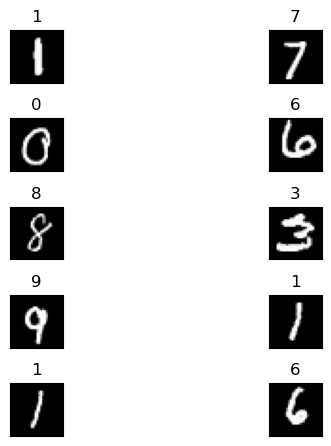

In [6]:
batch_data, batch_label = next(iter(train_loader))
viewPlots(batch_data,batch_label,10)

In [7]:

class MNet(nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=128,
        kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(num_features=128)
        self.tns1 = nn.Conv2d(in_channels=128, out_channels=4,
        kernel_size=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=4, out_channels=16,
        kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(num_features=16)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=16,
        kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(num_features=16)
        self.conv4 = nn.Conv2d(in_channels=16, out_channels=32,
        kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(num_features=32)
       
        self.pool2 = nn.MaxPool2d(2, 2)
        self.tns2 = nn.Conv2d(in_channels=32, out_channels=16,
        kernel_size=1, padding=1)
        
        self.conv5 = nn.Conv2d(in_channels=16, out_channels=16,
        kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(num_features=16)
        self.conv6 = nn.Conv2d(in_channels=16, out_channels=32,
        kernel_size=3, padding=1)
        self.bn6 = nn.BatchNorm2d(num_features=32)
        self.conv7 = nn.Conv2d(in_channels=32, out_channels=10,
        kernel_size=1, padding=1)
        self.gpool = nn.AvgPool2d(kernel_size=7)
        self.drop = nn.Dropout2d(0.15)


    
    def forward(self,x):
        x = self.tns1(self.drop(self.bn1(F.relu(self.conv1(x))))) #28>26
        x = self.drop(self.bn2(F.relu(self.conv2(x))))
        x = self.pool1(x)
        x = self.drop(self.bn3(F.relu(self.conv3(x))))
        x = self.bn4(F.relu(self.conv4(x)))
        x = self.tns2(self.pool2(x))
        x = self.bn5(F.relu(self.conv5(x)))
        x = self.bn6(F.relu(self.conv6(x)))
        x = self.conv7(x)
        x = self.gpool(x)
        x = x.view(-1, 10)
        return F.log_softmax(x)


In [8]:
model = MNet().to(device)
summary(model,input_size=(1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 128, 28, 28]           1,280
       BatchNorm2d-2          [-1, 128, 28, 28]             256
         Dropout2d-3          [-1, 128, 28, 28]               0
            Conv2d-4            [-1, 4, 30, 30]             516
            Conv2d-5           [-1, 16, 30, 30]             592
       BatchNorm2d-6           [-1, 16, 30, 30]              32
         Dropout2d-7           [-1, 16, 30, 30]               0
         MaxPool2d-8           [-1, 16, 15, 15]               0
            Conv2d-9           [-1, 16, 15, 15]           2,320
      BatchNorm2d-10           [-1, 16, 15, 15]              32
        Dropout2d-11           [-1, 16, 15, 15]               0
           Conv2d-12           [-1, 32, 15, 15]           4,640
      BatchNorm2d-13           [-1, 32, 15, 15]              64
        MaxPool2d-14             [-1, 3

C:\Users\maitr\AppData\Local\Temp\ipykernel_9832\1026459373.py:49: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


In [9]:
from tqdm import tqdm
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    pbar = tqdm(train_loader)
    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        pbar.set_description(desc= f'epoch: {epoch} loss={loss.item()} batch_id={batch_idx}')


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target,
                reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)
            correct +=pred.eq(target.view_as(pred)).sum().item()
            test_loss /= len(test_loader.dataset)
        print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.1f}%)\n'.format(test_loss, correct,len(test_loader.dataset), 100. * correct /len(test_loader.dataset)))

In [10]:
model = MNet().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.035, momentum=0.9)
for epoch in range(1, 20):
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, val_loader)

  0%|          | 0/782 [00:00<?, ?it/s]C:\Users\maitr\AppData\Local\Temp\ipykernel_9832\1026459373.py:49: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)
epoch: 1 loss=0.09143894910812378 batch_id=781: 100%|██████████| 782/782 [00:11<00:00, 65.51it/s]  



Test set: Average loss: 0.0001, Accuracy: 9773/10000 (97.7%)



epoch: 2 loss=0.11102701723575592 batch_id=781: 100%|██████████| 782/782 [00:11<00:00, 67.07it/s]   



Test set: Average loss: 0.0000, Accuracy: 9836/10000 (98.4%)



epoch: 3 loss=0.01735030673444271 batch_id=781: 100%|██████████| 782/782 [00:11<00:00, 66.31it/s]   



Test set: Average loss: 0.0001, Accuracy: 9879/10000 (98.8%)



epoch: 4 loss=0.005265339277684689 batch_id=781: 100%|██████████| 782/782 [00:11<00:00, 66.22it/s]  



Test set: Average loss: 0.0000, Accuracy: 9879/10000 (98.8%)



epoch: 5 loss=0.001410020631738007 batch_id=781: 100%|██████████| 782/782 [00:11<00:00, 65.43it/s]  



Test set: Average loss: 0.0000, Accuracy: 9896/10000 (99.0%)



epoch: 6 loss=0.0022829221561551094 batch_id=781: 100%|██████████| 782/782 [00:11<00:00, 65.49it/s] 



Test set: Average loss: 0.0000, Accuracy: 9889/10000 (98.9%)



epoch: 7 loss=0.00318407011218369 batch_id=781: 100%|██████████| 782/782 [00:12<00:00, 64.42it/s]   



Test set: Average loss: 0.0000, Accuracy: 9884/10000 (98.8%)



epoch: 8 loss=0.00412887753918767 batch_id=781: 100%|██████████| 782/782 [00:12<00:00, 64.21it/s]   



Test set: Average loss: 0.0000, Accuracy: 9910/10000 (99.1%)



epoch: 9 loss=0.0008040930260904133 batch_id=781: 100%|██████████| 782/782 [00:12<00:00, 64.21it/s] 



Test set: Average loss: 0.0000, Accuracy: 9909/10000 (99.1%)



epoch: 10 loss=0.001293974812142551 batch_id=781: 100%|██████████| 782/782 [00:12<00:00, 64.59it/s]  



Test set: Average loss: 0.0000, Accuracy: 9916/10000 (99.2%)



epoch: 11 loss=0.10802942514419556 batch_id=781: 100%|██████████| 782/782 [00:12<00:00, 64.56it/s]   



Test set: Average loss: 0.0000, Accuracy: 9924/10000 (99.2%)



epoch: 12 loss=0.0010451488196849823 batch_id=781: 100%|██████████| 782/782 [00:12<00:00, 64.22it/s]  



Test set: Average loss: 0.0000, Accuracy: 9916/10000 (99.2%)



epoch: 13 loss=0.004369339905679226 batch_id=781: 100%|██████████| 782/782 [00:12<00:00, 64.07it/s]   



Test set: Average loss: 0.0000, Accuracy: 9915/10000 (99.2%)



epoch: 14 loss=0.028632456436753273 batch_id=781: 100%|██████████| 782/782 [00:12<00:00, 63.93it/s]  



Test set: Average loss: 0.0000, Accuracy: 9922/10000 (99.2%)



epoch: 15 loss=0.030563028529286385 batch_id=781: 100%|██████████| 782/782 [00:12<00:00, 63.92it/s]   



Test set: Average loss: 0.0002, Accuracy: 9912/10000 (99.1%)



epoch: 16 loss=0.004989263601601124 batch_id=781: 100%|██████████| 782/782 [00:12<00:00, 64.15it/s]   



Test set: Average loss: 0.0000, Accuracy: 9909/10000 (99.1%)



epoch: 17 loss=0.00495445542037487 batch_id=781: 100%|██████████| 782/782 [00:12<00:00, 63.46it/s]    



Test set: Average loss: 0.0000, Accuracy: 9924/10000 (99.2%)



epoch: 18 loss=0.0018961868481710553 batch_id=781: 100%|██████████| 782/782 [00:12<00:00, 63.88it/s]  



Test set: Average loss: 0.0000, Accuracy: 9922/10000 (99.2%)



epoch: 19 loss=0.0001893716398626566 batch_id=781: 100%|██████████| 782/782 [00:12<00:00, 64.01it/s]  



Test set: Average loss: 0.0000, Accuracy: 9919/10000 (99.2%)

